In [1]:
import os
import subprocess

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import unidecode
import itertools

In [2]:
# ensure data is downloaded and available
for folder in ['name_data', 'replication_data', 'figures']:
    if folder not in os.listdir('../'):
        os.mkdir('../%s'%folder)
        
def download_if_necessary(folder, file):
    if file not in os.listdir('../%s'%folder):
        subprocess.run(['osf', '-p', 'tz38q', 'fetch', 
                        '%s/%s'%(folder, file), '%s/%s'%(folder, file)], cwd="../")

### Figure Parameters

In [3]:
plt.rc('font', family='Helvetica')

combined_colors = {'purple':(40, 37, 70),'lightpurple':(84, 88, 116),
                   'blue':(84, 130, 154),'lightblue':(165, 188, 198),
                   'green':(66, 81, 45),'lightgreen':(164, 196, 99, ), # green: (120, 151, 59, )
                   'yellow':(244, 199, 72, ),'lightyellow':(245, 230, 98),
                   'orange':(230, 121, 62),'lightorange':(255,157,72),
                   'red':(135, 41, 43),'lightred':(185, 63, 63)
                   }
combined_colors = {c:np.array(v)/256 for c,v in combined_colors.items()}

## Load Data

In [4]:
download_if_necessary('name_data', 'source-aggregated_name-gender_associations.json')
source_associations = json.load(open('../name_data/source-aggregated_name-gender_associations.json','r'))

download_if_necessary('name_data', 'averaged_name-gender_estimates.json')
avg_estimates = json.load(open('../name_data/averaged_name-gender_estimates.json','r'))

# convert dictionary to dataframe
avg_estimates_df = pd.DataFrame(avg_estimates).T

download_if_necessary('replication_data', 'country-decade-aggregated_estimates.json')
aggregates = json.load(open('../replication_data/country-decade-aggregated_estimates.json','r'))

### Interactively find names at different levels of coverage
- finneus: $10^2$
- garreth $10^3$
- Abdellah $10^4$
- madelyn $10^5$
- alexander $10^6$

In [5]:
i = 5
l,h = 10**i + np.array([-(10**(i-1)), 10**(i-1)])
level_df = avg_estimates_df.loc[(avg_estimates_df['M_counts'] > l)&
                                (avg_estimates_df['M_counts'] < h)].copy()
level_df['d'] = abs(level_df['M_counts'] - 10**i)
# level_df.sort_values(by='d').head(10)

#### Find a name more strongly gendered female in USA and more strongly gendered male globally

In [6]:
candidate_switches = []
for name, counts in source_associations.items():
    try:
        us_estimate = counts['1']['f']/(counts['1']['f'] + counts['1']['m'])
        if us_estimate > .7:
            avg_estimate = avg_estimates[name]['AVG_estimate']
            if avg_estimate < .3:
                candidate_switches.append((name,int(avg_estimates[name]['M_counts'])))
    except:
        continue
        
print(sorted(candidate_switches, key = lambda x: x[1], reverse=True)[:10])

[('robin', 462286), ('jan', 252311), ('remi', 112411), ('matti', 83038), ('ollie', 70959), ('sakari', 65447), ('presley', 29601), ('loris', 29382), ('kalle', 20299), ('tomi', 20158)]


## Load Benchmark Datasets

In [7]:
for file in ['santamaría_benchmark.csv', 'vogel_benchmark.csv', 'morgan_benchmark.csv']:
    download_if_necessary('replication_data', file)

santa = pd.read_csv('../replication_data/santamaría_benchmark.csv',
                            keep_default_na=False)
vogel = pd.read_csv('../replication_data/vogel_benchmark.csv',
                            keep_default_na=False)
morgan = pd.read_csv('../replication_data/morgan_benchmark.csv', # osf version anonymized 
                               keep_default_na=False) 

In [8]:
benchmarks = [(santa, '36'), (vogel, '32'), (morgan, '-1')]

### Taxonomize Names

In [9]:
def parse_aggregate(d):
    return np.array([v[:2] for v in d.values()])


def parse_name(n):
    return unidecode.unidecode(str(n)).lower().strip().split(' ')[0]


def validation_average(n,ns):
    try:
        estimates = [v['f']/(v['f']+v['m'])
             for k, v in source_associations[n].items() if k != ns]

        return np.mean(estimates) if len(estimates) > 0 else np.nan
    except:
        return np.nan


def compute_uncertainty(estimates_pops):
    estimates, pops = estimates_pops.T
    weights = pops/pops.sum()
    return np.dot(.5 - abs(.5 - estimates),weights)


def compute_meta_data(n, ns):
    try:
        n_data = avg_estimates[n]
        e = validation_average(n, ns)
        count = n_data['M_counts']
        e_u = compute_uncertainty(np.array([[e,1]]))
    except:
        e = np.nan
        count = 0
        e_u = .5
    try:
        c_u = compute_uncertainty(parse_aggregate(aggregates[n]['c']))
    except:
        c_u = np.nan
    try:
        d_u = compute_uncertainty(parse_aggregate(aggregates[n]['d']))
    except:
        d_u = np.nan
    
    return (e, count, (e_u, c_u, d_u))


def taxonomize_name(n, ns, min_count, max_u):
    e, c, u = compute_meta_data(parse_name(n), ns)
    if np.isnan(e):
        return 'No Data'
    elif u[0] <= max_u:
        if c >= min_count:
            return 'Gendered (high coverage)'
        else:
            return 'Gendered (low coverage)'
    else:
        if u[1] <= max_u:
            return 'Conditionally Gendered (country)'
        elif u[2] <= max_u:
            return 'Conditionally Gendered (decade)'
        return 'Weakly Gendered'
    
    
def taxonomize(names, ns = '-1', min_count = 10, max_u = .1):
    return [taxonomize_name(n,ns,min_count,max_u) for n in names]

In [10]:
for df, s in benchmarks:
    df['l'] = taxonomize(df['first_name'], s)

In [11]:
tx = 100 * pd.concat((pd.DataFrame(santa.groupby('l').count()['first_name']/len(santa)),
pd.DataFrame(vogel.groupby('l').count()['first_name']/len(vogel)),
pd.DataFrame(morgan.groupby('l').count()['first_name']/len(morgan))), axis = 1)
tx.columns = ['santa','vogel','morgan']

In [12]:
dataset_labels  = ['Santamaría', 'Vogel', 'Morgan']

tx_labels = ['Gendered (high coverage)',
             'Gendered (low coverage)',
             'Conditionally Gendered (country)',
             'Conditionally Gendered (decade)',
             'Weakly Gendered',
             'No Data']

coarse_tx_labels = ['No Data', 'Weakly Gendered',
                      'Conditionally Gendered', 'Gendered (low coverage)',
                      'Gendered (high coverage)']

coarse_tx = tx.copy()
coarse_tx.loc['Conditionally Gendered'] = coarse_tx.loc[[l for l in tx_labels if 'Con' in l]].sum(axis=0)
coarse_tx = coarse_tx.drop([l for l in tx_labels if 'con' in l]).loc[coarse_tx_labels]
coarse_tx.columns = dataset_labels

In [13]:
tx.round(1).loc[tx_labels]

,santa,vogel,morgan
l,,,
Gendered (high coverage),76.2,83.2,88.0
Gendered (low coverage),3.9,3.2,1.7
Conditionally Gendered (country),8.9,5.8,5.1
Conditionally Gendered (decade),0.2,0.2,0.1
Weakly Gendered,8.0,4.8,4.0
No Data,2.8,2.8,1.0


In [14]:
# # most common gender (high coverage) names
# Counter(pd.concat([df.loc[df['l'] == 'Gendered (high coverage)'] for df,
#                    _ in benchmarks])['first_name'].values).most_common()

### Figure 2.A

In [15]:
comp_colors = tx_colors = [combined_colors[x] for x in ['red','yellow','orange','green','blue']]

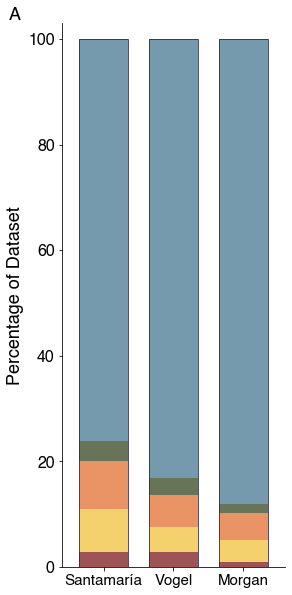

In [16]:
fig, ax = plt.subplots(figsize=(4,10))

width = .7
prev = np.array([0.,0.,0.])

for c,vals in zip(comp_colors,coarse_tx.values):

    ax.bar(dataset_labels, vals, width, bottom=prev, color=c,alpha=.8)
    prev += vals

ax.bar(dataset_labels, [100,100,100], width, color='none', edgecolor=combined_colors['purple'],linewidth=1,alpha=.8)


plt.xlim(-.6,2.6)
plt.ylim(0,103)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(fontsize=15)
plt.yticks(fontsize=16)
plt.ylabel('Percentage of Dataset', fontsize=18)

ax.text(-0.24, 1.03, 'A', transform=ax.transAxes, fontname='Helvetica',
                    fontsize=18, fontweight='bold', va='top', ha='left')

plt.savefig('../figures/dataset_taxonomy_breakdown.png',facecolor='white',bbox_inches='tight',dpi=150)

plt.show()

### Compute CCT Estimates

In [17]:
def EM_CCT(bin_responses):
    N = bin_responses.shape[0]
    M = (~np.isnan(bin_responses)).sum(axis=1)

    competencies = np.ones(N)*.9
    consensus = np.zeros(M.shape[0])

    def update_consensus():
        c = np.nanprod(bin_responses*competencies.reshape(N,-1) +
                       (1-bin_responses)*(1-competencies).reshape(N,-1),axis=0)
        e = np.nanprod(bin_responses*(1-competencies).reshape(N,-1) +
                       (1-bin_responses)*competencies.reshape(N,-1),axis=0)

        return(c / (c+e))

    def update_competencies():
        return(np.nansum(bin_responses*consensus.reshape(1,-1) +
                         (1-bin_responses)*(1-consensus).reshape(1,-1),axis=1)/M)
    
    for i in range(100):
        previous = competencies
        
        consensus = update_consensus()
        competencies = update_competencies()
        if np.sum((previous - competencies)**2) < 1e-10:
            break
        
    consensus = update_consensus()
    return(consensus,competencies)

In [18]:
def prep_run_CCT(names, threshold = .1, N = 36, drop = []):
    names = [parse_name(n) for n in names]
    sources = np.ones(N)
    for s in drop:
        sources[int(s)-1] = 0
    
    estimated_names = []
    all_estimates = []
    
    j = 0
    for i,n in enumerate(names):
        estimates = np.nan*np.zeros(N)
        
        try:
            ratios = {s:v['f']/(v['f']+v['m']) for s, v in source_associations[n].items() if sources[int(s)-1] == 1}
            if len(ratios.items()) == 0:
                estimated_names.append([n,i,-1])
            else:
                for s,v in ratios.items():                        

                    if v < (.5-threshold):
                        estimates[int(s)-1] = 0
                    elif v > (.5+threshold):
                        estimates[int(s)-1] = 1
                            
                all_estimates.append(estimates)
                estimated_names.append([n,i,j])
                j += 1
        except:
            estimated_names.append([n,i,-1])
            
    cct_estimates, _ = EM_CCT(np.array(all_estimates).T[sources.astype(bool)])
    final_cct = [cct_estimates[k] if k != -1 else np.nan for i,j,k in estimated_names]
    return final_cct

## Compute Correspondence

In [19]:
def convert_ratio_to_class(r,threshold=0.):
    if np.isnan(r):
        return('-')
    elif r < (.5 - threshold):
        return('m')
    elif r > (.5 + threshold):
        return('f')
    else:
        return('u')

### Figure 2.B
Note: anonymized data causes a minor computational issue

In [20]:
for df,s in benchmarks:
    df['avg'] = [validation_average(parse_name(n),s) for n in df['first_name']]
    df['avg_b'] = [convert_ratio_to_class(r) for r in df['avg'].values]
    df['cct'] = prep_run_CCT(df['first_name'], drop = [s] if s != '-1' else [])
    df['cct_b'] = [convert_ratio_to_class(r) for r in df['cct'].values]

In [21]:
cct_metrics = {k:[] for k in dataset_labels}
for k,(df,_) in zip(dataset_labels,benchmarks):
    for sub in list((tx_labels,tx_labels[0:1],tx_labels[1:2],tx_labels[2:4],tx_labels[4:5],tx_labels[5:])):
        preds, targets = df.loc[df['l'].isin(sub),['cct_b','gender']].values.T
        num = (preds == targets).sum()
        den = sum([p in ['m','f'] for p in preds])
        cct_metrics[k].append([num,den,len(targets)])

In [22]:
plt.rcParams['font.size'] = 16

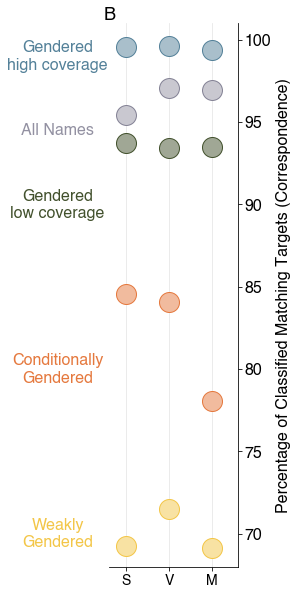

In [23]:
fig, ax = plt.subplots(figsize=(4,10))
colors = [combined_colors[x] for x in ['purple','blue','green','orange','yellow','red']]

text_locs = [94.5,99,90,80,70]
labels = ['All Names','Gendered\nhigh coverage','Gendered\nlow coverage','Conditionally\nGendered','Weakly\nGendered']
for i,t in enumerate(labels):
    alpha = 1 if i != 0 else .5
    correspondence = 100*np.array([v[i][0]/v[i][1] for k,v in cct_metrics.items()])
    
    plt.scatter([0,1,2],
                correspondence,
                s=400,
                facecolor = (1,1,1,1),
                edgecolor = (1,1,1,1),
                zorder=3,
                marker='o')
    plt.scatter([0,1,2],
                correspondence,
                s=400,
                facecolor = tuple(colors[i])+tuple([alpha/2]),
                edgecolor = tuple(colors[i])+tuple([alpha]),
                zorder=6,
                marker='o')
    
    plt.annotate(t,xy=(-1.6,text_locs[i]),# + np.mean(correspondence)
                 horizontalalignment='center',va='center',
                 c=tuple(colors[i])+tuple([alpha]))


plt.xlim(-2.6,2.6)
# plt.xlim(-.6,5.6)
plt.ylim(68,101)

plt.xticks([0,1,2],['S', 'V', 'M']);

# Hide the right and top spines
# ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# limit length of x spine
ax.spines['bottom'].set_bounds(-.4,2.6)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('bottom')

plt.xticks(fontsize=14)
plt.yticks(fontsize=16)

plt.ylabel('Percentage of Classified Matching Targets (Correspondence)')
ax.yaxis.set_label_position("right")

# plt.tight_layout()

ax.text(0.4, 1.03, 'B', transform=ax.transAxes, fontname='Helvetica',
                    fontsize=18, fontweight='bold', va='top', ha='left')

# grid
ax.set_axisbelow(True)
ax.grid(axis='x',zorder=-1,alpha=.3,ls='-')


plt.savefig('../figures/dataset_taxonomy_performance.png',facecolor='white',bbox_inches='tight',dpi=150)

plt.show()

### Extra Metrics for Section on Assessment

In [24]:
# performance numbers across taxonomy
p_df = []
for i,t in enumerate(labels):
    p_df.append([t]+ list(100*np.array([v[i][0]/v[i][1] for k,v in cct_metrics.items()])))
pd.DataFrame(p_df,columns=['l','s','v','m']).round(1)

,l,s,v,m
0,All Names,95.4,97.1,97.0
1,Gendered\nhigh coverage,99.5,99.6,99.4
2,Gendered\nlow coverage,93.7,93.4,93.5
3,Conditionally\nGendered,84.6,84.1,78.1
4,Weakly\nGendered,69.3,71.5,69.1


In [25]:
# performance change on conditionally gendered names when jean and robin are dropped
for df,_ in benchmarks:
    print('-')
    conditioned = df.loc[(df['l'].str.contains('Conditionally Gendered'))&(df['cct_b'].isin(['m','f']))]
    dropped = conditioned.loc[~conditioned['first_name'].isin(['jean','robin'])]
    print(np.round(100*np.mean(conditioned['cct_b'] == conditioned['gender']),0))
    print(np.round(100*np.mean(dropped['cct_b'] == dropped['gender']),0))

-
85.0
84.0
-
84.0
84.0
-
78.0
81.0


In [26]:
# % not classified
for df,_ in benchmarks:
    print(100*(1 - np.mean(df['cct_b'].isin(['m','f']))))

2.9595015576323935
2.9816513761467878
1.085141903171949


In [27]:
# % of difference in performance explained by differences in composition
var_explained = []
for i,origin in enumerate(['Santamaría','Vogel','Morgan']):
    for j,target in enumerate(['Santamaría','Vogel','Morgan']):
        if i < j:
            o_percents = coarse_tx.copy()[origin].values[::-1]
            t_percents = coarse_tx.copy()[target].values[::-1]
            d_percents = o_percents - t_percents
            x = np.dot(o_percents,np.array([x[0]/x[2] for x in cct_metrics[origin][1:]]))
            y = np.dot(t_percents,np.array([x[0]/x[2] for x in cct_metrics[target][1:]]))
            o_percents[0] += sum(d_percents[-2:])
            o_percents[-2:] -= d_percents[-2:]
            z = np.dot(o_percents,np.array([x[0]/x[2] for x in cct_metrics[origin][1:]]))
            var_explained.append(1 - abs(y - z)/abs(y - x))
print(np.mean(var_explained))

0.7962410946983841


## Load Classifier Comparison Data

In [28]:
download_if_necessary('replication_data', 'classifier_comparison_data.json')
class_comps = json.load(open('../replication_data/classifier_comparison_data.json','r'))

### Figure 3.A

In [29]:
comp_labels = ['cct']+['genderize', 'api', 'onograph', 'namsor']

In [30]:
comp_metrics = {}
comp_metrics['cct'] = cct_metrics['Santamaría']
for k in comp_labels[1:]:
    comp_metrics[k] = []
    santa[k+'_b'] = [convert_ratio_to_class(r) for r in class_comps[k]['santa']]
    for sub in list((tx_labels,tx_labels[0:1],tx_labels[1:2],tx_labels[2:4],tx_labels[4:5],tx_labels[5:])):
        preds, targets = santa.loc[santa['l'].isin(sub),[k+'_b','gender']].values.T
        num = (preds == targets).sum()
        den = sum([p in ['m','f'] for p in preds])
        comp_metrics[k].append([num,den,len(targets)])

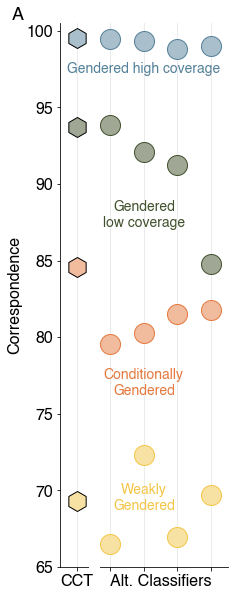

In [31]:
fig, ax = plt.subplots(figsize=(3,10))
plt.rcParams['font.size'] = 14
colors = [combined_colors[x] for x in ['purple','blue','green','orange','yellow','red']]

markers = ['h','o','o','o','o']


for i in range(1,5):
    
    correspondence = 100*np.array([v[i][0]/v[i][1] for k,v in comp_metrics.items()])
    for x,y in enumerate(correspondence):
        plt.scatter(x,
                    y,
                    s=400,
                    facecolor = tuple(colors[i])+tuple([.5]),
                    edgecolor = tuple(colors[i])+tuple([1]) if x != 0 else (0,0,0,1),
                    marker=markers[x],zorder=6)
        plt.scatter(x,
                    y,
                    s=400,
                    facecolor = (1,1,1,1),
                    edgecolor = (1,1,1,1),
                    marker=markers[x],zorder=3)
        
        
text_locs = [96,97.5,88,77,69.5]
labels = ['All Names','Gendered high coverage','Gendered\nlow coverage','Conditionally\nGendered','Weakly\nGendered']
for i,(y,t) in enumerate(zip(text_locs,labels)):
    if i == 0:
        continue
    plt.annotate(t,xy=(2,y),
                 horizontalalignment='center',va='center',fontsize=14,
                 c=tuple(colors[i])+tuple([1]))
        

plt.xlim(-.5,4.5)
plt.ylim(65,100.5)

ax.scatter([.5],[65],100,
           color='white',clip_on=False,zorder=10)
  
plt.xticks([0,1,2,3,4],['CCT','','','',''])
plt.xlabel('Alt. Classifiers',labelpad=10)
ax.xaxis.set_label_coords(.5+.1,-.0125)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# grid
ax.set_axisbelow(True)
ax.grid(axis='x',zorder=-1,alpha=.3,ls='-')

plt.ylabel('Correspondence')

ax.text(-0.29, 1.03, 'A', transform=ax.transAxes, fontname='Helvetica',
                    fontsize=18, fontweight='bold', va='top', ha='left')

plt.savefig('../figures/classifier_taxonomy_performance.png',facecolor='white',bbox_inches='tight',dpi=150)

plt.show()

In [32]:
# performance numbers across taxonomy
p_df = []
for i,t in enumerate(labels+['No Data']):
    p_df.append([t]+ list(100*np.array([v[i][0]/v[i][1] if v[i][1] != 0 else 0 for k,v in comp_metrics.items()])))
pd.DataFrame(p_df).round(1)

,0,1,2,3,4,5
0,All Names,95.4,94.7,94.9,94.0,93.8
1,Gendered high coverage,99.5,99.5,99.3,98.8,99.0
2,Gendered\nlow coverage,93.7,93.8,92.1,91.2,84.8
3,Conditionally\nGendered,84.6,79.5,80.3,81.5,81.8
4,Weakly\nGendered,69.3,66.5,72.3,67.0,69.7
5,No Data,0.0,87.1,84.4,79.7,71.8


In [33]:
# when we have no data, what % does at least one paid service have no data
some_miss = ((santa.loc[santa['l'] == 'No Data',['genderize_b','api_b','onograph_b','namsor_b']] == '-').sum(axis=1) != 0).sum()
some_miss / santa.loc[santa['l'] == 'No Data'].shape[0]

0.558282208588957

### Figures 3.B & 3.C

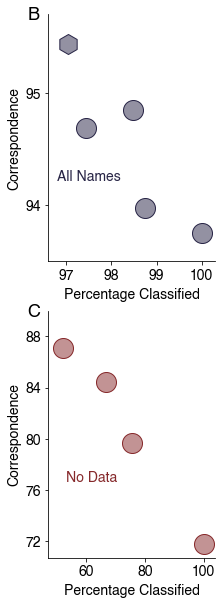

In [34]:
plt.rcParams['font.size'] = 14
colors = [combined_colors[x] for x in ['purple','blue','green','orange','yellow','red']]

markers = ['h','o','o','o','o']

gs_kw = dict(height_ratios=[1, 1],hspace=0.2, wspace=0.05)
fig, axd = plt.subplot_mosaic([['ur'],['b']],
                              gridspec_kw=gs_kw, figsize=(3, 10),)

axd['ur'].spines['right'].set_visible(False)
axd['ur'].spines['top'].set_visible(False)

axd['b'].spines['right'].set_visible(False)
axd['b'].spines['top'].set_visible(False)
axd['b'].yaxis.set_ticks_position('left')
axd['b'].xaxis.set_ticks_position('bottom')

for i,t in enumerate(comp_labels):
    mets = comp_metrics[t]
    axd['ur'].scatter(100*mets[0][1]/mets[0][2],
                100*mets[0][0]/mets[0][1],
                s=400,
                facecolor = tuple(colors[0])+tuple([.5]),
                edgecolor = tuple(colors[0])+tuple([1]),
                marker=markers[i])
    
    if i != 0:
        axd['b'].scatter(100*mets[-1][1]/mets[-1][2],
                    100*mets[-1][0]/mets[-1][1],
                    s=400,
                    facecolor = tuple(colors[-1])+tuple([.5]),
                    edgecolor = tuple(colors[-1])+tuple([1]),
                    marker=markers[i])
    
axd['ur'].annotate('All Names',xy=(97.5,94.25),
                 horizontalalignment='center',va='center',fontsize=14,
                 c=tuple(colors[0])+tuple([1]))
    
axd['b'].annotate('No Data',xy=(62,77),
                 horizontalalignment='center',va='center',fontsize=14,
                 c=tuple(colors[-1])+tuple([1]))

axd['ur'].set_xlim(96.6,100.3)
axd['b'].set_xlim(47,104)

axd['ur'].set_ylim(93.5,95.7)
axd['b'].set_ylim(70.7,90)

plt.sca(axd['ur'])
plt.xticks(np.arange(97,101),[97,98,99,100]); 

plt.yticks([94,95],[94,95]); 
plt.ylabel('Correspondence')

plt.sca(axd['b'])
plt.yticks(np.arange(72,89,4),np.arange(72,89,4)); 
plt.ylabel('Correspondence')

axd['ur'].set_xlabel('Percentage Classified',labelpad=5)
axd['b'].set_xlabel('Percentage Classified',labelpad=5)

axd['ur'].annotate('CCT',(95.5,95.15))

axd['ur'].text(-0.1225, 1.03, 'B', transform=axd['ur'].transAxes, fontname='Helvetica',
                    fontsize=18, fontweight='bold', va='top', ha='left')
axd['b'].text(-0.1225, 1.03, 'C', transform=axd['b'].transAxes, fontname='Helvetica',
                    fontsize=18, fontweight='bold', va='top', ha='left')

plt.savefig('../figures/classifier_taxonomy_classified.png',facecolor='white',bbox_inches='tight',dpi=150)

plt.show()

In [35]:
# % no data names classified
[v[-1][1]/v[-1][2] for k,v in comp_metrics.items()]

[0.0, 0.5214723926380368, 0.6687116564417178, 0.754601226993865, 1.0]

In [36]:
[v[0][1]/v[0][2] for k,v in comp_metrics.items()]

[0.9704049844236761,
 0.9743856005538248,
 0.9847698165455174,
 0.9875389408099688,
 1.0]

### Figure 3.D

In [37]:
cutoffs = [.05,.15,.25,.35,.5]
cut_labels = ['0.95 - 1.00', '0.85 - 0.94', '0.75 - 0.84','0.65 - 0.74','0.50 - 0.64','No Data']

x = santa['avg'].values
err = (.5 - abs(.5 - x))
santa['err'] = err
santa['n'] = 'No Data'
santa.loc[err <= cutoffs[0], 'n'] = '0.95 - 1.00'
santa.loc[(err > cutoffs[0])&(err <= cutoffs[1]), 'n'] = '0.85 - 0.94'
santa.loc[(err > cutoffs[1])&(err <= cutoffs[2]), 'n'] = '0.75 - 0.84'
santa.loc[(err > cutoffs[2])&(err <= cutoffs[3]), 'n'] = '0.65 - 0.74'
santa.loc[(err > cutoffs[3])&(err <= cutoffs[4]), 'n'] = '0.50 - 0.64'

In [38]:
cut_metrics = {}
for k in comp_labels:
    cut_metrics[k] = []
    for sub in cut_labels:
        preds, targets = santa.loc[(santa['n'] == sub)&(santa['first_name']!='jean'),
                                   [k+'_b','gender']].values.T
        num = (preds == targets).sum()
        den = sum([p in ['m','f'] for p in preds])
        cut_metrics[k].append([num,den,len(targets)])

In [39]:
jean_performance = 100*np.mean(santa.loc[santa['first_name'] == 'jean','gender'].values == 'm')

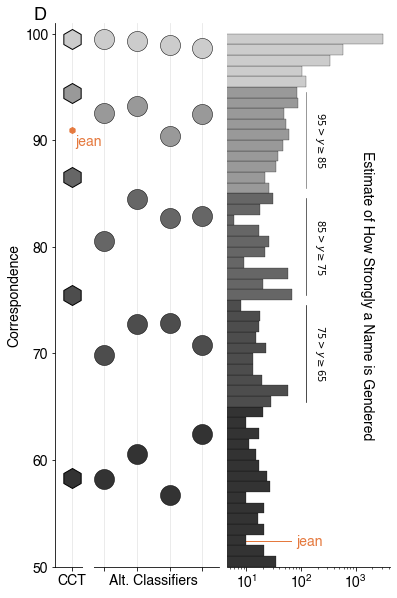

In [40]:
plt.rcParams['font.size'] = 14
colors = [(i/10,i/10,i/10,1) for i in [2,3,4,6,8]][::-1]

gs_kw = dict(width_ratios=[1, 1],hspace=0.2, wspace=0.05)
fig, axd = plt.subplot_mosaic([['l', 'r']],
                              gridspec_kw=gs_kw, figsize=(6, 10),)

ax = axd['l']

markers = ['h','o','o','o','o']

ax.scatter(0,
            jean_performance,
            color=combined_colors['orange'],marker='h')


for i,_ in enumerate(cut_labels[:-1]):
    for j,t in enumerate(comp_labels):
        mets = cut_metrics[t][i]
        c = tuple(colors[i])
        ax.scatter(j,
                    100*mets[0]/mets[1],
                    s=400,
                    facecolor = c,
                    edgecolor = (0,0,0,1),lw=.5 if j != 0 else 1,
                    marker=markers[j],zorder=2.5)
        
plt.sca(axd['l'])      
plt.xlim(-.5,4.5)
plt.ylim(50,101)
plt.ylabel('Correspondence')


plt.xticks([0,1,2,3,4],['CCT','','','',''])
plt.xlabel('Alt. Classifiers',labelpad=10)
ax.xaxis.set_label_coords(.5+.1,-.0125)


plt.annotate('jean',(.5,jean_performance-1.4),
             rotation=0,ha='center',color=combined_colors['orange'])# va='center'

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(-.5,4.5)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


# grid
ax.set_axisbelow(True)
ax.grid(axis='x',zorder=-1,alpha=.3,ls='-')

ax.scatter([.5],[50],100,
           color='white',clip_on=False,zorder=10)

ax = axd['r']
plt.sca(axd['r']) 

    
plt.rcParams['font.size'] = 10
for c,a,b,l,d,t in zip(colors[1:-1],cutoffs[:-2],
                 cutoffs[1:-1],
                 [125,125,125],
                 [.2,.2,.2,],
                 ["$95>y\geq85$", "$85>y\geq75$", "$75>y\geq65$"]):
    plt.annotate("",xy=(125, 100*(1-a)),zorder=0,
                xytext=(125, 100*(1-b)),color=c,
                arrowprops=dict(arrowstyle="-", color=c,lw=1,
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="bar,fraction=%f"%0),
                                )
    plt.annotate(t,(l+100,50*(1-a) + 50*(1-b)),rotation=-90, va='center',ha='center')
plt.rcParams['font.size'] = 14   

N, bins, patches = plt.hist(100*(1-santa.loc[santa['first_name']!='jean','err']),
                            bins=50,edgecolor='black', linewidth=.25,orientation='horizontal',zorder=3);

for c,(l,h) in enumerate(zip(cutoffs,[0]+cutoffs[:-1])):
    for i in np.arange(len(bins))[(bins >= 100*(1-l)) & (bins < 100*(1-h))]:
        patches[i].set_facecolor(colors[c])    

jean_err = 100 * (1 - santa.loc[santa['first_name'] == 'jean','err'].values[0])
plt.annotate('jean',
             (80,jean_err),color=combined_colors['orange'],ha='left', va='center')# va='center'
plt.plot([0,santa.loc[santa['first_name'] == 'jean'].shape[0]],
         [jean_err,jean_err],alpha=1,zorder=1,lw=1,color=combined_colors['orange'])


plt.ylim(50,101)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
plt.yticks([],[])

plt.xscale('log')

plt.ylabel('Estimate of How Strongly a Name is Gendered', rotation=-90)
ax.yaxis.set_label_position("right")
ax.yaxis.set_label_coords(.9,.5)

axd['l'].text(-0.135, 1.03, 'D', transform=axd['l'].transAxes, fontname='Helvetica',
                    fontsize=18, fontweight='bold', va='top', ha='left')

plt.savefig('../figures/classified_correspondence_bins_counts.png',facecolor='white',bbox_inches='tight',dpi=150)

plt.show()

### Figure 4
Note: Anonymized data does somewhat poorly here.

In [41]:
download_if_necessary('replication_data', 'genni_ethnea.json')
genni_ethnea = json.load(open('../replication_data/genni_ethnea.json','r'))

ethnea_codes = dict(zip(
    ['VIETNAMESE','CARIBBEAN', 'INDIAN', 'INDONESIAN', 'ARAB', 'GREEK','POLYNESIAN','BALTIC', 'AFRICAN', 
     'TURKISH', 'ENGLISH', 'GERMAN','SLAV', 'THAI', 'CHINESE', 'KOREAN', 'NORDIC', 'FRENCH', 'DUTCH', 
     'HUNGARIAN', 'ITALIAN', 'JAPANESE','ISRAELI', 'ROMANIAN','HISPANIC','MONGOLIAN','TOOSHORT','UNKNOWN','ERROR'],
    ['VNM','CUB', 'IND', 'IDN', 'EGY', 'GRC', 'PYF', 'LTU', 'NGA', 
     'TUR', 'GBR', 'DEU','RUS', 'THA', 'CHN', 'KOR', 'SWE', 'FRA', 'NLD', 
     'HUN', 'ITA', 'JPN', 'ISR', 'ROU','ESP','MNG','XXX','XXX','XXX']))

In [42]:
def compute_genni_estimates(df):
    genni = []
    for f,l in df[['first_name','last_name']].values.astype(str):
        try:
            response = genni_ethnea[f+'+'+l]
            genni.append(response['Genni'].lower())
        except:
            genni.append('-')
    return genni


def compute_conditional_estimates(df):
    conditional = []
    for f,l in df[['first_name','last_name']].values.astype(str):
        try:
            response = genni_ethnea[f+'+'+l]
            c = ethnea_codes[response['Ethnea'].split('-')[0]]
            if c == 'XXX':
                est = '-'
            else:
                est = convert_ratio_to_class(aggregates[f]['c'][c][0])
        except:
            est = '-'
        conditional.append(est)
    return conditional

In [43]:
for df,_ in benchmarks:
    df['genni_b'] = compute_genni_estimates(df)
    df['country_b'] = compute_conditional_estimates(df)

---

In [44]:
def compute_conditional_performance(preds, n = 10000):
    samples = []
    for i in range(n):
        d = preds.sample(frac=1,replace=True)
        diffs = []
        for m in ['country_b','genni_b']:
            diffs.append(sum([x if x != '-' else y for x,y in d[[m,'cct_b']].values] == d['gender']) 
                       - sum(d['cct_b'] == d['gender']))
        samples.append(diffs)
    samples = np.array(samples).T
    d = preds
    diffs = []
    for m in ['country_b','genni_b']:
        diffs.append(sum([x if x != '-' else y for x,y in d[[m,'cct_b']].values] == d['gender']) 
                   - sum(d['cct_b'] == d['gender']))
    return [(diffs[0], np.quantile(samples[0], q = [.025,.975])),
            (diffs[1], np.quantile(samples[1], q = [.025,.975])),
            len(d)]

In [45]:
conditional_performance = []
for df,_ in benchmarks:
    conditional_performance.append(compute_conditional_performance(df.loc[df['l'] == 'Conditionally Gendered (country)',
                                           ['cct_b','genni_b','country_b','gender']]))

---

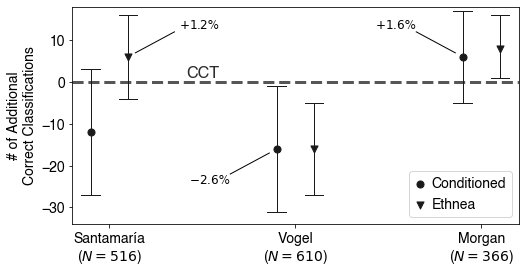

In [46]:
fig, ax = plt.subplots(figsize=(8,4))
plt.rcParams['font.size'] = 16
colors = [combined_colors[x] for x in ['purple','blue','green','orange','yellow','red']]
for i,performance in enumerate(conditional_performance):
    if i == 0:
        plt.scatter(i-.1,performance[0][0],color='.1',label='Conditioned',s=50,marker='o')
        plt.scatter(i+.1,performance[1][0],color='.1',label='Ethnea',s=50,marker='v')
    else:
        plt.scatter(i-.1,performance[0][0],color='.1',s=50,marker='o')
        plt.scatter(i+.1,performance[1][0],color='.1',s=50,marker='v')
        
    plt.plot([i-.1,i-.1],performance[0][1],color='.1',zorder=2.5,lw=1)
    plt.plot([i-.1-.05,i-.1+.05],
             [performance[0][1][0],performance[0][1][0]],color='.1',zorder=2.5,lw=1)
    plt.plot([i-.1-.05,i-.1+.05],
             [performance[0][1][1],performance[0][1][1]],color='.1',zorder=2.5,lw=1)

    plt.plot([i+.1,i+.1],performance[1][1],color='.1',zorder=2.5,lw=1)
    plt.plot([i+.1-.05,i+.1+.05],
             [performance[1][1][0],performance[1][1][0]],color='.1',zorder=2.5,lw=1)
    plt.plot([i+.1-.05,i+.1+.05],
             [performance[1][1][1],performance[1][1][1]],color='.1',zorder=2.5,lw=1)
    
plt.axhline(0,c=np.ones(3)*44/256,alpha=.8,lw=3,zorder=0,ls='--')

plt.ylabel('# of Additional\nCorrect Classifications')

plt.xticks([0,1,2], ['Santamaría\n('r'$N=%d$)'%conditional_performance[0][-1],
                     'Vogel\n('r'$N=%d$)'%conditional_performance[1][-1],
                     'Morgan\n('r'$N=%d$)'%conditional_performance[2][-1]])
plt.xlim(-.2,2.2)
plt.ylim(-34,18)

plt.rcParams['font.size'] = 14
plt.legend(loc='lower right',handletextpad=.4,handlelength=.8)
plt.rcParams['font.size'] = 16

# ax.text(-0.14, 1.03, 'B', transform=ax.transAxes, fontname='Helvetica',
#                     fontsize=18, fontweight='bold', va='top', ha='left')


ax.text(.292, .66, 'CCT', transform=ax.transAxes, fontname='Helvetica',
                    fontsize=16, fontweight='regular', va='bottom', ha='center',c=np.ones(3)*44/256)


plt.plot([.14,.35],[conditional_performance[0][1][0] +.98, conditional_performance[0][1][0] + 6],c='k',lw=1)
plt.annotate(''r'$+%.1f$'%(100*conditional_performance[0][1][0]/conditional_performance[0][2])+"%",
             xy=(.35+.025,conditional_performance[0][1][0] + 6),va="bottom",ha="left",fontsize=12)

plt.plot([1-.04-.1,1-.25-.1],[conditional_performance[1][0][0] -.98, conditional_performance[1][0][0] - 6],c='k',lw=1)
plt.annotate(''r'$%.1f$'%(100*conditional_performance[1][0][0]/conditional_performance[1][2])+"%",
             xy=(1-.25-.1,conditional_performance[1][0][0] - 6),va="top",ha="right",fontsize=12)

plt.plot([2-.14,1.65],[conditional_performance[2][0][0] +.98, conditional_performance[2][0][0] + 6],c='k',lw=1)
plt.annotate(''r'$+%.1f$'%(100*conditional_performance[2][0][0]/conditional_performance[2][2])+"%",
             xy=(1.65,conditional_performance[2][0][0] + 6),va="bottom",ha="right",fontsize=12)


plt.savefig('../figures/delta_matching_using_country.png',facecolor='white',bbox_inches='tight',dpi=150)
plt.show()

In [47]:
# % of conditionally gendered that are country dependent
for df,_ in benchmarks:
    conditioned = df.loc[(df['l'].str.contains('Conditionally Gendered'))]
    print(df.loc[(df['l'] == 'Conditionally Gendered (country)')].shape[0]/conditioned.shape[0])

0.9791271347248577
0.9651898734177216
0.973404255319149


In [48]:
# how often do classifications change when we condition on country
same = [0,0]
tot = [0,0]
for df,_ in benchmarks:
    conditioned = df.loc[(df['l'] == 'Conditionally Gendered (country)')]
    c,g = conditioned.loc[(conditioned['genni_b'].isin(['m','f']))&
                (conditioned['cct_b'].isin(['m','f'])),['cct_b','genni_b']].values.T
    same[0] += np.sum(c == g)
    tot[0] += len(c)
    
    c,g = conditioned.loc[(conditioned['country_b'].isin(['m','f']))&
                (conditioned['cct_b'].isin(['m','f'])),['cct_b','country_b']].values.T
    same[1] += np.sum(c == g)
    tot[1] += len(c)
    
1-np.array(same)/np.array(tot)

array([0.08225617, 0.1162608 ])

In [49]:
# how often do jean and andrea change
all_df = pd.concat([df.loc[(df['l'] == 'Conditionally Gendered (country)'),
                           ['first_name','gender','l','cct_b','genni_b','country_b']] for df,_ in benchmarks])

In [50]:
all_df.loc[(all_df['cct_b'].isin(['m','f']))&
           (all_df['country_b'].isin(['m','f']))&
           (all_df['cct_b']!=all_df['country_b']),'first_name'].value_counts().head()

andrea    15
jean       9
simone     8
joan       7
alexis     6
Name: first_name, dtype: int64

In [51]:
all_df.loc[(all_df['cct_b'].isin(['m','f']))&
           (all_df['country_b'].isin(['m','f'])),'first_name'].value_counts().head()

jan       94
jean      83
chris     51
andrea    39
robin     27
Name: first_name, dtype: int64

In [52]:
(15+9)/(83+39) 

0.19672131147540983

### Figure 5

In [53]:
def compute_missing_performance(preds, n = 10000):
    missing = preds.loc[preds['l']=='No Data',['namsor_b', 'gender']]
    samples = []
    for i in range(n):
        d = missing.sample(frac=1,replace=True)
        samples.append((np.sum(d['namsor_b'] == d['gender']) - np.sum(d['gender'] == 'm')))
        
    d = missing
    diff = (np.sum(d['namsor_b'] == d['gender']) - np.sum(d['gender'] == 'm'))
    return [(diff, np.quantile(samples, q = [.025,.975])),len(d)]

In [54]:
vogel['namsor_b'] = [convert_ratio_to_class(r) for r in class_comps['namsor']['vogel']]
morgan['namsor_b'] = [convert_ratio_to_class(r) for r in class_comps['namsor']['morgan']]

In [55]:
missing_performance = []
for df,_ in benchmarks:    
    missing_performance.append(compute_missing_performance(df))

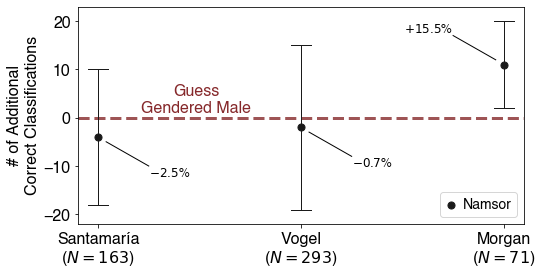

In [56]:
fig, ax = plt.subplots(figsize=(8,4))
plt.rcParams['font.size'] = 16
colors = [combined_colors[x] for x in ['purple','blue','green','orange','yellow','red']]#['b','r','g','k','y']

for i,performance in enumerate(missing_performance):
    
    if i == 0:
        plt.scatter(i,performance[0][0],color='.1',label='Namsor',s=50,marker='o')
    else:
        plt.scatter(i,performance[0][0],color='.1',s=50,marker='o')
    plt.plot([i,i],performance[0][1],color='.1',zorder=2.5,lw=1)
    plt.plot([i-.05,i+.05],
             [performance[0][1][0],performance[0][1][0]],color='.1',zorder=2.5,lw=1)
    plt.plot([i-.05,i+.05],
             [performance[0][1][1],performance[0][1][1]],color='.1',zorder=2.5,lw=1)



plt.axhline(0,c=colors[-1],alpha=.8,lw=3,zorder=0,ls='--')

plt.ylabel('# of Additional\nCorrect Classifications')
# plt.yticks([],[])

plt.xticks([0,1,2], ['Santamaría\n('r'$N=%d$)'%missing_performance[0][-1],
                     'Vogel\n('r'$N=%d$)'%missing_performance[1][-1],
                     'Morgan\n('r'$N=%d$)'%missing_performance[2][-1]])


plt.xlim(-.1,2.1)
plt.ylim(-22,23)

plt.rcParams['font.size'] = 14
plt.legend(loc='lower right',handletextpad=.4,handlelength=.8)
plt.rcParams['font.size'] = 16

# ax.text(-0.14, 1.03, 'C', transform=ax.transAxes, fontname='Helvetica',
#                     fontsize=18, fontweight='bold', va='top', ha='left')

ax.text(.265, .5, 'Guess\nGendered Male', transform=ax.transAxes, fontname='Helvetica',
                    fontsize=16, fontweight='regular', va='bottom', ha='center',c=colors[-1])


plt.plot([.04,.25],[missing_performance[0][0][0] -.98, missing_performance[0][0][0] - 6],c='k',lw=1)
plt.annotate(''r'$%.1f$'%(100*missing_performance[0][0][0]/missing_performance[0][1])+"%",
             xy=(.25,missing_performance[0][0][0] - 6),va="top",ha="left",fontsize=12)

plt.plot([1.04,1.25],[missing_performance[1][0][0] -.98, missing_performance[1][0][0] - 6],c='k',lw=1)
plt.annotate(''r'$%.1f$'%(100*missing_performance[1][0][0]/missing_performance[1][1])+"%",
             xy=(1.25,missing_performance[1][0][0] - 6),va="top",ha="left",fontsize=12)

plt.plot([2-.04,1.75],[missing_performance[2][0][0] +.98, missing_performance[2][0][0] + 6],c='k',lw=1)
plt.annotate(''r'$+%.1f$'%(100*missing_performance[2][0][0]/missing_performance[2][1])+"%",
             xy=(1.75,missing_performance[2][0][0] + 6),va="bottom",ha="right",fontsize=12)


plt.savefig('../figures/delta_matching_using_namsor.png',facecolor='white',bbox_inches='tight',dpi=150)
plt.show()

In [57]:
# Namsor correspondence on no data names
for df,_ in benchmarks:
    n,g = df.loc[df['l']=='No Data',['namsor_b', 'gender']].values.T
    print(np.round(100*np.mean(n==g),1), np.round(100*np.mean('m'==g),1))

71.8 74.2
76.8 77.5
76.1 60.6


In [58]:
# namsor confidence
all_labels = np.array(list(itertools.chain.from_iterable([df['l'].values for df,_ in benchmarks])))

In [59]:
all_namsor = np.array(list(itertools.chain.from_iterable([v for k,v in class_comps['namsor'].items()])))

In [60]:
(2*abs(.5 - all_namsor))[all_labels == 'Weakly Gendered'].mean()

0.36191369757706765

In [61]:
(2*abs(.5 - all_namsor))[all_labels != 'Weakly Gendered'].mean()

0.8995016429969204

### Figure 6

In [62]:
def compute_avg_performance(preds, n = 10000):
    avg = preds[['avg_b','cct_b', 'gender']]
    samples = []
    for i in range(n):
        d = avg.sample(frac=1,replace=True)
        samples.append((np.sum(d['avg_b'] == d['gender']) - np.sum(d['cct_b'] == d['gender'])))
        
    d = avg

    diff = (np.sum(d['avg_b'] == d['gender']) - np.sum(d['cct_b'] == d['gender']))
    return [(diff, np.quantile(samples, q = [.025,.975])),len(d)]

In [63]:
avg_performance = []
for df,_ in benchmarks:    
    avg_performance.append(compute_avg_performance(df))

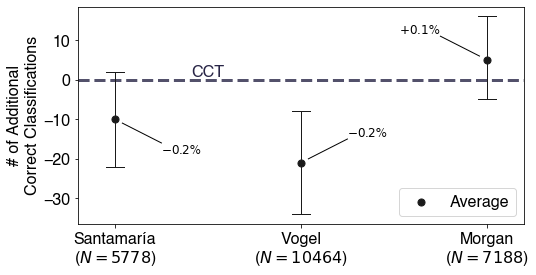

In [64]:
fig, ax = plt.subplots(figsize=(8,4))
plt.rcParams['font.size'] = 16
colors = [combined_colors[x] for x in ['purple','blue','green','orange','yellow','red']]#['b','r','g','k','y']

    
for i,performance in enumerate(avg_performance):
    
    if i == 0:
        plt.scatter(i,performance[0][0],color='.1',label='Average',s=50,marker='o')
    else:
        plt.scatter(i,performance[0][0],color='.1',s=50,marker='o')
    plt.plot([i,i],performance[0][1],color='.1',zorder=2.5,lw=1)
    plt.plot([i-.05,i+.05],
             [performance[0][1][0],performance[0][1][0]],color='.1',zorder=2.5,lw=1)
    plt.plot([i-.05,i+.05],
             [performance[0][1][1],performance[0][1][1]],color='.1',zorder=2.5,lw=1)
    
    
plt.axhline(0,c=colors[0],alpha=.8,lw=3,zorder=0,ls='--')
plt.ylabel(''r'$\Delta$ Matching Classifications')
plt.legend(loc='lower right')

plt.xticks([0,1,2], ['Santamaría\n('r'$N=%d$)'%avg_performance[0][-1],
                     'Vogel\n('r'$N=%d$)'%avg_performance[1][-1],
                     'Morgan\n('r'$N=%d$)'%avg_performance[2][-1]])
plt.xlim(-.2,2.2)

plt.ylabel('# of Additional\nCorrect Classifications')

ax.text(.292, .665, 'CCT', transform=ax.transAxes, fontname='Helvetica',
                    fontsize=16, fontweight='regular', va='bottom', ha='center',c=colors[0])


plt.plot([.04,.25],[avg_performance[0][0][0] -.98, avg_performance[0][0][0] - 6],c='k',lw=1)
plt.annotate(''r'$%.1f$'%(100*avg_performance[0][0][0]/avg_performance[0][1])+"%",
             xy=(.25,avg_performance[0][0][0] - 6),va="top",ha="left",fontsize=12)

plt.plot([1.04,1.25],[avg_performance[1][0][0] +.98, avg_performance[1][0][0] + 6],c='k',lw=1)
plt.annotate(''r'$%.1f$'%(100*avg_performance[1][0][0]/avg_performance[1][1])+"%",
             xy=(1.25,avg_performance[1][0][0] + 6),va="bottom",ha="left",fontsize=12)

plt.plot([2-.04,1.75],[avg_performance[2][0][0] +.98, avg_performance[2][0][0] + 6],c='k',lw=1)
plt.annotate(''r'$+%.1f$'%(100*avg_performance[2][0][0]/avg_performance[2][1])+"%",
             xy=(1.75,avg_performance[2][0][0] + 6),va="bottom",ha="right",fontsize=12)


plt.savefig('../figures/delta_matching_cct_avg.png',facecolor='white',bbox_inches='tight',dpi=150)
plt.show()

In [65]:
# ssa coverage and % classified
def ssa_average(n):
    try:
        ssa = source_associations[n]['1']
        return ssa['f']/(ssa['f']+ssa['m'])
    except:
        return np.nan
    
santa['ssa_b'] = [convert_ratio_to_class(ssa_average(parse_name(n))) for n in santa['first_name']]

x,y = santa.loc[santa['ssa_b'].isin(['m','f']),['gender','ssa_b']].values.T
np.mean(x == y), len(x)/len(santa)

(0.9310272094494833, 0.8205261336102457)

In [66]:
# avg coverage and % classified
x,y = santa.loc[santa['avg_b'].isin(['m','f']),['gender','avg_b']].values.T
np.mean(x == y), len(x)/len(santa)

(0.9546023235031278, 0.9683281412253375)

In [67]:
# avg coverage and % classified (only gendered)
x,y = santa.loc[(santa['avg_b'].isin(['m','f']))&
                (santa['l'].isin(['Gendered (high coverage)','Gendered (low coverage)'])),
                ['gender','avg_b']].values.T
np.mean(x == y), len(x)/len(santa)

(0.9926454683106208, 0.8001038421599169)

### Discussion stats

In [68]:
# avg matches cct
np.mean(santa['avg_b'] == santa['cct_b'])

0.9923849082727587

In [69]:
# how many gendered male and female fall into gendered (high coverage) subset
for df, _ in benchmarks:
    kept = []
    for g in ['f', 'm']:
        kept.append(df.loc[(df['gender']==g)&
                  (df['l']=='Gendered (high coverage)')].shape[0]/sum(df['gender'] == g))
    print(kept,kept[0]-kept[1])
    print('---')

[0.7809959349593496, 0.7514435695538058] 0.029552365405543846
---
[0.7770034843205574, 0.8522517777192521] -0.07524829339869465
---
[0.8514851485148515, 0.8969750109601052] -0.04548986244525377
---


In [70]:
# composition estimates
for df, _ in benchmarks:
    df_g = df.loc[(df['l']=='Gendered (high coverage)')]
    print(100*np.round((df['gender'] == 'm').mean(),5) ,
          100*np.round((df_g.loc[df_g['avg_b'].isin(['m','f']),'avg_b'] == 'm').mean(),5))

65.94 65.023
72.573 74.512
63.467 65.139


In [71]:
# error rates by group
def compute_gender_errors(preds):
    f = sum(preds['gender'] == 'f')
    m = sum(preds['gender'] == 'm')
    fm = sum((preds['gender'] == 'f')&(preds['avg_b'] == 'm'))
    mf = sum((preds['gender'] == 'm')&(preds['avg_b'] == 'f'))
    return(np.round(100*fm/f,5) - np.round(100*mf/m,5))

print(compute_gender_errors(santa))

print(compute_gender_errors(vogel))

print(compute_gender_errors(morgan))

1.2704900000000001
5.27156
2.52071


In [72]:
# overall error rates
all_benchmarks = pd.concat([x[0] for x in benchmarks])
for g,e in zip(['m', 'f'],['f', 'm']):
    print(100*np.mean(all_benchmarks.loc[(all_benchmarks['gender'] == g),'avg_b'] == e))

2.2172115745960164
5.560021436227224


In [73]:
# nationality issues
c_l_pairs = []
for f,l,label in santa[['first_name','last_name','l']].values:
    try:
        response = genni_ethnea[f+'+'+l]
        c = response['Ethnea'].split('-')[0]
        c_l_pairs.append((c,label))
    except:
        contiue
        
def country_info(c):
    d = [(x,y) for x,y in c_l_pairs if x == c]
    n = len([y for x,y in d if (y == 'Weakly Gendered' or y == 'No Data')])
    return n/len(d)

country_info('CHINESE'), country_info('ENGLISH')

(0.4678492239467849, 0.04929577464788732)

---

In [74]:
# extra bit on male / female names
for g in ['m','f']:
    gtx = 100 * pd.concat((pd.DataFrame(santa.loc[santa['gender']==g].groupby('l').count()['first_name']
                                        /len(santa.loc[santa['gender']==g])),
    pd.DataFrame(vogel.loc[vogel['gender']==g].groupby('l').count()['first_name']
                 /len(vogel.loc[vogel['gender']==g])),
    pd.DataFrame(morgan.loc[morgan['gender']==g].groupby('l').count()['first_name']
                 /len(morgan.loc[morgan['gender']==g]))), axis = 1)
    gtx.columns = ['santa','vogel','morgan']
    print(gtx.round(1).loc[tx_labels])

                                  santa  vogel  morgan
l                                                     
Gendered (high coverage)           75.1   85.2    89.7
Gendered (low coverage)             4.5    3.5     1.8
Conditionally Gendered (country)    8.5    4.6     3.7
Conditionally Gendered (decade)     0.2    0.2     0.2
Weakly Gendered                     8.5    3.4     3.6
No Data                             3.2    3.0     0.9
                                  santa  vogel  morgan
l                                                     
Gendered (high coverage)           78.1   77.7    85.1
Gendered (low coverage)             2.7    2.4     1.5
Conditionally Gendered (country)    9.8    9.0     7.4
Conditionally Gendered (decade)     0.2    0.2     0.1
Weakly Gendered                     7.1    8.4     4.8
No Data                             2.1    2.3     1.1
